# Beauty Classifier


In [3]:
!pip install wget

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Setup and Helpers

In [8]:
# Imports
%run ../src/utils/helpers.py

from collections import defaultdict
import requests
import boto3
import tempfile
import wget

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
# Initialization
s3 = boto3.resource('s3')
bucket_name = 'eye-of-the-needle'
bucket = s3.Bucket(bucket_name)

In [6]:
# Download pre-trained weights
print('Beginning file download of pre-trained weights')
url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'  
filepath = '../models/vgg16_weights.h5'
wget.download(url, filepath)  

Beginning file download of pre-trained weights


'../models/vgg16_weights.h5'


Displaying images scored 1:
['2018/03/15/2018_0315_133000/thumbnail.jpg']


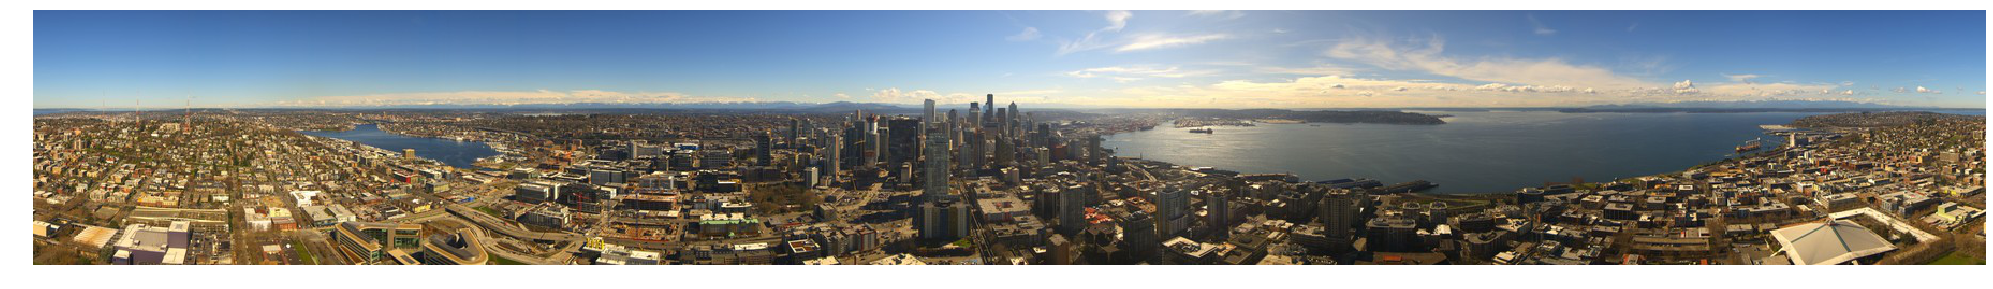

In [10]:
# Helper functions
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record


def display_images(n, score=1):
    record = get_record()
    l = list(record.keys())

    n_files = []
    while len(n_files) < n:
        f = random.choice(l)
        if record[f]['score'] == score:
            n_files.append(f)

    print(f"\nDisplaying images scored {score}:")
    print(n_files)
    fig = plt.figure(figsize=(35, 12))
    for i, file in enumerate(n_files):
        obj = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            obj.download_fileobj(f)
            img=mpimg.imread(tmp.name)
        ax = fig.add_subplot(n, 1, i + 1) 
        ax.imshow(img)
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    return img
n = 1
img = display_images(n, 1)

In [28]:
img.shape

(237, 1820, 3)

# Explore Data

In [16]:
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record

record = get_record()
scores = sum(v['score'] for k, v in record.items())
print(f"{scores} great photos out of {len(record.keys())} photos scored")

429 great photos out of 2032 photos scored


# Prep Data

In [38]:
dm = pd.DataFrame.from_dict(record, orient='index').reset_index().sort_values(by='index')
dm = dm[dm['matches'] == 1].drop('matches', axis=1)
display(dm.shape)
dm.head()

(2032, 2)

,index,score
0,2017/06/15/2017_0615_093000/thumbnail.jpg,0
1,2017/06/15/2017_0615_143000/thumbnail.jpg,0
2,2017/06/15/2017_0615_165000/thumbnail.jpg,0
3,2017/06/16/2017_0616_070000/thumbnail.jpg,1
4,2017/06/16/2017_0616_143000/thumbnail.jpg,0


# Classifier

In [13]:
# Get VGG16 pretrained weights
url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'


print('Beginning file download with wget module')

url = 'http://i3.ytimg.com/vi/J---aiyznGQ/mqdefault.jpg'  
wget.download(url, '/Users/scott/Downloads/cat4.jpg') 